# TODO:
1. refine prompt ---DONE---
2. threshold code (sim between question and refs) ---DONE---
3. dedup code---DONE---
4. generate lots of questions ---DONE---

In [1]:
import pickle
with open('questions_references.pkl', 'rb') as f:
    questions_references = pickle.load(f)

In [44]:
import tiktoken

# Count the number of tokens in each page_content
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string, disallowed_special=()))
    return num_tokens

In [5]:
import random

# Sample 10 questions randomly
sample_questions = random.sample(questions_references, 15)

for question in sample_questions:
    if len(question[1]) > 1:
        print(question[0])


What specific directives and actions did President Biden announce regarding international relations and military operations in his State of the Union Address?
What specific actions did President Biden mention in his speech regarding climate change and worker's rights?
What initiatives and policies did President Biden focus on in his State of the Union Address?
What actions has President Biden taken to address gun violence, according to his State of the Union Address?
What measures does President Biden's bipartisan border security bill include to address border challenges?
What specific actions did President Biden mention he has taken regarding gun violence and police reform in his State of the Union Address?
What key points did President Biden emphasize about the role of unions and the middle class in America during his State of the Union Address?
What actions has President Biden pledged regarding hostages held by Hamas and others detained by the Russians?
What recent developments in N

In [32]:
with open('../data/state_of_the_union.md', 'r') as file:
    data = file.read()

In [35]:
from openai import OpenAI
import os
import json
import random

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

question_maker_prompt = """
You are an agent that generates questions from provided text. Your job is to generate a question and provide the relevant sections from the text as references.

Instructions:
1. For each provided text, generate a question that can be answered solely by the facts in the text.
2. Extract all significant facts that answer the generated question.
3. Format the response in JSON format with two fields:
   - 'question': A question directly related to these facts, ensuring it can only be answered using the references provided.
   - 'references': A list of all text sections that answer the generated question. These must be exact copies from the original text and should be whole sentences where possible.

Notes: 
Make the question more specific.
Do not ask a question about multiple topics. 
Do not ask a question with over 5 references.

Example:

Text: "Experiment A: The temperature control test showed that at higher temperatures, the reaction rate increased significantly, resulting in quicker product formation. However, at extremely high temperatures, the reaction yield decreased due to the degradation of reactants.

Experiment B: The pH sensitivity test revealed that the reaction is highly dependent on acidity, with optimal results at a pH of 7. Deviating from this pH level in either direction led to a substantial drop in yield.

Experiment C: In the enzyme activity assay, it was found that the presence of a specific enzyme accelerated the reaction by a factor of 3. The absence of the enzyme, however, led to a sluggish reaction with an extended completion time.

Experiment D: The light exposure trial demonstrated that UV light stimulated the reaction, making it complete in half the time compared to the absence of light. Conversely, prolonged light exposure led to unwanted side reactions that contaminated the final product."

Response: {
  'question': 'What experiments were done in this paper?',
  'references': ['Experiment A: The temperature control test showed that at higher temperatures, the reaction rate increased significantly, resulting in quicker product formation.', 'Experiment B: The pH sensitivity test revealed that the reaction is highly dependent on acidity, with optimal results at a pH of 7.', 'Experiment C: In the enzyme activity assay, it was found that the presence of a specific enzyme accelerated the reaction by a factor of 3.', 'Experiment D: The light exposure trial demonstrated that UV light stimulated the reaction, making it complete in half the time compared to the absence of light.']
}
"""

In [34]:
def normalize_text(input_text: str) -> str:
    """
    Normalize the input text by replacing special characters with standard ones.
    
    Args:
        input_text (str): The text to normalize.
        
    Returns:
        str: The normalized text.
    """
    # Define mappings from special characters to standard ones
    replacements = {
        '‘': "'", '’': "'", '“': '"', '”': '"', '″': '"', '′': "'",
        '–': '-', '—': '-', '…': '...', '«': '"', '»': '"', "\n": ""
    }
    
    # Replace each character in the input text based on the mappings
    for special, standard in replacements.items():
        input_text = input_text.replace(special, standard)
    
    return input_text

def find_target_in_document(document, target):
    norm_corpus = normalize_text(document)
    norm_target = normalize_text(target)
    start_index = norm_corpus.find(norm_target)
    if start_index == -1:
        if norm_target[-1] == ".":
            start_index = norm_corpus.find(norm_target[:-1])
            if start_index == -1:
                return None
        else:
            return None
    start_index = start_index + document[:start_index].count("\n")
    end_index = start_index + len(target)
    return start_index, end_index

def get_sub_string(document, start_index, end_index):
    return document[start_index:end_index]


In [30]:
# 1800 characters because this is roughly under 400 tokens
def extract_question_and_references(corpus, text_description, document_length=4000, prev_questions=[]):
    if len(corpus) > document_length:
        start_index = random.randint(0, len(corpus) - document_length)
        document = corpus[start_index : start_index + document_length]
    else:
        document = corpus
    questions_sample = random.sample(prev_questions, 50)
    prev_questions_str = '\n'.join(questions_sample)
    completion = client.chat.completions.create(
        model="gpt-4-turbo",
        response_format={ "type": "json_object" },
        max_tokens=600,
        messages=[
            {"role": "system", "content": question_maker_prompt},
            {"role": "user", "content": f"Text Description:{text_description}\n\nText: {document}\n\nThe following questions have already been used. Do not repeat them:{prev_questions_str}Respond with references and a question in JSON."}
        ]
    )
    
    json_response = json.loads(completion.choices[0].message.content)
    
    try:
        text_references = json_response['references']
    except KeyError:
        raise ValueError("The response does not contain a 'references' field.")
    try:
        question = json_response['question']
    except KeyError:
        raise ValueError("The response does not contain a 'question' field.")

    references = []
    for reference in text_references:
        target = find_target_in_document(corpus, reference)
        if target is not None:
            start_index, end_index = target
            references.append((reference, start_index, end_index))
        else:
            raise ValueError(f"No match found in the document for the given reference.\nReference: {reference}")
    
    return question, references

In [43]:
question, references = extract_question_and_references(data, "This is a transcribed segment from President Biden's State of the Union Address.", 4000, [x[0] for x in new_question_references])

In [37]:
(question, references)

('What financial benefits did President Biden mention in the State of the Union Address regarding prescription drugs for seniors under Medicare?',
 [('Starting next year, the same law caps total prescription drug costs for seniors on Medicare at $200 \n— at $2,000 a year, even for expensive cancer drugs that cost $10-, $12-, $15,000.',
   16308,
   16491)])

In [95]:
from openai import OpenAI
import os
import numpy as np

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

def get_sim(target, references):
    response = client.embeddings.create(
        input=[target]+references,
        model="text-embedding-3-large"
    )
    cosine_similarities = []
    nparray1 = np.array(response.data[0].embedding)

    full_sim = []
    for i in range(1, len(response.data)):
        nparray2 = np.array(response.data[i].embedding)
        cosine_similarity = np.dot(nparray1, nparray2) / (np.linalg.norm(nparray1) * np.linalg.norm(nparray2))
        # cosine_similarities.append(cosine_similarity)
        full_sim.append((target, references[i-1], cosine_similarity))
    # return np.mean(cosine_similarities)
    
    return full_sim


In [97]:
cosine_similarities = []

for i, (question, ref_list) in enumerate(questions_references):
    cosine_sim = get_sim(question, [x[0] for x in ref_list])
    cosine_similarities.extend(cosine_sim)
    # print(f"Question {i + 1}: {question}")
    if i == 1:
        print(f"{i} Mean cosine similarity: {cosine_sim}")

1 Mean cosine similarity: [("What reasons did President Biden give for the failure of a particular bill's passage?", 'But unfortunately, politics have derailed this bill so far.', 0.4293684108240673), ("What reasons did President Biden give for the failure of a particular bill's passage?", 'I’m told my predecessor called members of Congress in the Senate to demand they block the bill. He feels political win — he viewed it as a — it would be a political win for me and a political loser for him.', 0.47190147718124054)]


In [98]:
cosine_similarities

[("What significant regulatory changes and proposals has President Biden's administration implemented or announced regarding fees and pricing transparency?",
  'My administration announced we’re cutting credit card late fees from $32 to $8.',
  0.4190307867642103),
 ("What significant regulatory changes and proposals has President Biden's administration implemented or announced regarding fees and pricing transparency?",
  'My administration has proposed rules to make cable, travel, utilities, and online ticket sellers tell you the total price up front so there are no surprises.',
  0.5220460324372589),
 ("What reasons did President Biden give for the failure of a particular bill's passage?",
  'But unfortunately, politics have derailed this bill so far.',
  0.4293684108240673),
 ("What reasons did President Biden give for the failure of a particular bill's passage?",
  'I’m told my predecessor called members of Congress in the Senate to demand they block the bill. He feels political wi

Mean:  0.474881086402703
Standard Deviation: 0.11588877984000573
Median: 0.4734036573024803
Top 75%: 0.5400379978760557
Bottom 25%: 0.40069928386476616


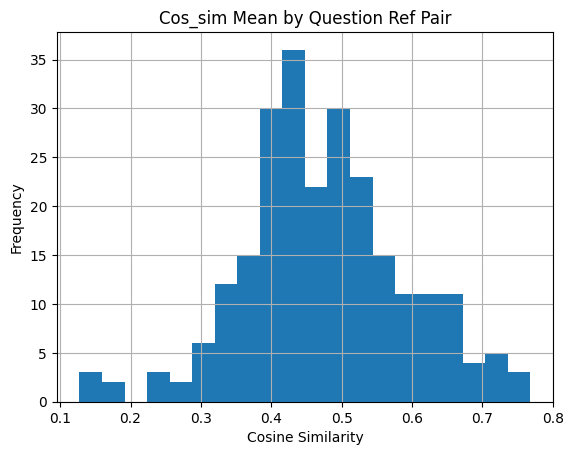

In [99]:
import matplotlib.pyplot as plt

cosine_scores = np.array([x[2] for x in cosine_similarities])
# cosine_scores = cosine_similarities[:, 2]
print("Mean: ", cosine_scores.mean())
print("Standard Deviation:", np.std(cosine_scores))
print("Median:", np.median(cosine_scores))
print("Top 75%:", np.percentile(cosine_scores, 75))
print("Bottom 25%:", np.percentile(cosine_scores, 25))

plt.hist(cosine_scores, bins=20)
plt.title('Cos_sim Mean by Question Ref Pair')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [22]:
cosine_similarities.sort(key=lambda x: x[2])
cosine_scores = np.array([x[2] for x in cosine_similarities])


In [87]:
percentile = 27.5

threshold = np.percentile(cosine_scores, percentile)
print(f"Threshold for the {percentile}th percentile: {threshold}")

questions = [x[0] for x in questions_references]
questions_count = len(questions)


# Find the number of questions this cuts and what percent of the dataset this is
num_question_refs_cut = sum(cosine_scores < threshold)

for x in cosine_similarities:
    if x[2] < threshold:
        questions = [q for q in questions if q != x[0]]

new_question_count = len(questions)

print(f"Number of pairs cut: {num_question_refs_cut}")
print(f"Number of questions cut: {questions_count - new_question_count}")
print(f"Number of questions left: {new_question_count}")
print(f"Percent of dataset cut: {(questions_count - new_question_count )/ questions_count * 100}%")

# Print 5 rows above and below this threshold
threshold_index = num_question_refs_cut

print("Questions about threshold:")
for i in range(threshold_index-4, threshold_index+6):
    print(cosine_similarities[i])
    if i == threshold_index:
        print("---Threshold---")



Threshold for the 27.5th percentile: 0.36087520205564627
Number of pairs cut: 162
Number of questions cut: 94
Number of questions left: 127
Percent of dataset cut: 42.53393665158371%
Questions about threshold:
('What actions has President Biden mentioned regarding gun control in his address?', "I'm proud we beat the NRA when I signed the most significant gun safety law in nearly 30 years because of this Congress.", 0.3595489002046565)
('What actions has President Biden taken or proposed regarding gun violence and gun control?', 'Keep building trust, as I’ve been doing, by taking executive action on police reform and calling for it to be the law of the land.', 0.3596389614783012)
('What actions has President Biden taken regarding gun violence and police reform?', "I'm proud we beat the NRA when I signed the most significant gun safety law in nearly 30 years because of this Congress.", 0.35975058728470444)
('What specific issues and proposals did President Biden address in his State of t

# Decided threshold
0.36 
We found this value by looking at multiple precentiles. I found the 27.5th percentile to continually produce good question pairs. Around 25th percentile were many bad pairs. 

In [100]:
threshold = 0.36
for x in cosine_similarities:
    if x[2] < threshold:
        questions_references = [q for q in questions_references if q[0] != x[0]]

In [101]:
len(questions_references)

97

In [25]:
new_question_references

[("What significant regulatory changes and proposals has President Biden's administration implemented or announced regarding fees and pricing transparency?",
  [('My administration announced we’re cutting credit card late fees from $32 to $8.',
    27340,
    27419),
   ('My administration has proposed rules to make cable, travel, utilities, and online ticket sellers tell you the total price up front so there are no surprises.',
    27858,
    28015)]),
 ('What key points did President Biden emphasize about the role of the middle class and unions in his State of the Union Address?',
  [('Showing once again Wall Street didn’t build America. They’re not bad guys. They didn’t build it, though. The middle class built the country, and unions built the middle class.',
    13523,
    13698),
   ('But I grew up in a home where trickle-down economics didn’t put much on my dad’s kitchen table. That’s why I’m determined to turn things around so the middle class does well. When they do well, the p

# Removing duplicate queries
Some queries effectively ask the exact same question but worded differently. This isn't ideal thus we remove them.

In [91]:
questions = [x[0] for x in questions_references]

response = client.embeddings.create(
    input=questions,
    model="text-embedding-3-large"
)

In [92]:
import numpy as np

embeddings_matrix = np.array([data.embedding for data in response.data])

dot_product_matrix = np.dot(embeddings_matrix, embeddings_matrix.T)

# Create a list of tuples containing the index pairs and their similarity
similarity_pairs = [(i, j, dot_product_matrix[i][j]) for i in range(len(dot_product_matrix)) for j in range(i+1, len(dot_product_matrix))]

# Sort the list of tuples based on the similarity in descending order
similarity_pairs.sort(key=lambda x: x[2], reverse=True)

similarity_scores = np.array([x[2] for x in similarity_pairs])


In [93]:
len(similarity_pairs)

6903

Mean:  0.4959101605084816
Standard Deviation: 0.13138965398606908
Median: 0.49112237958253185
Top 75%: 0.5754750864963314
Bottom 25%: 0.4103538489729157


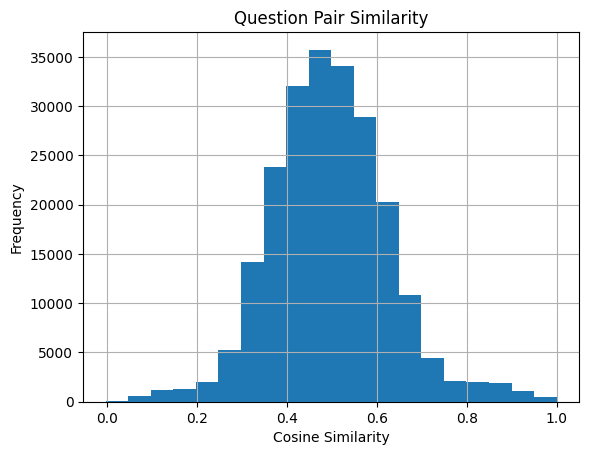

In [10]:
import matplotlib.pyplot as plt

similarity_scores = np.array([x[2] for x in similarity_pairs])
# cosine_scores = cosine_similarities[:, 2]
print("Mean: ", similarity_scores.mean())
print("Standard Deviation:", np.std(similarity_scores))
print("Median:", np.median(similarity_scores))
print("Top 75%:", np.percentile(similarity_scores, 75))
print("Bottom 25%:", np.percentile(similarity_scores, 25))

plt.hist(similarity_scores, bins=20)
plt.title('Question Pair Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Mean:  0.4166884062016862
Standard Deviation: 0.13288585448743093
Median: 0.4111163616410062
Top 75%: 0.49570574670346657
Bottom 25%: 0.33452490966471093


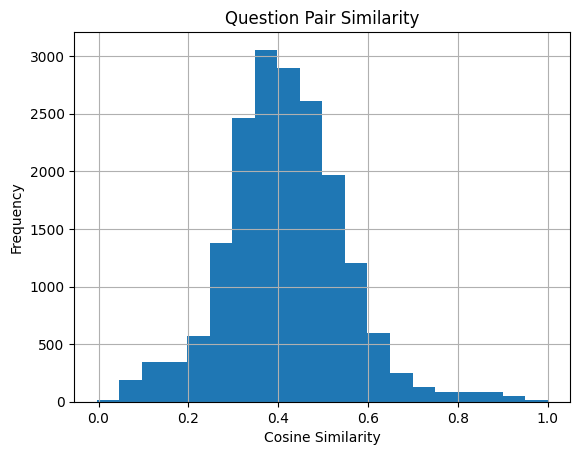

In [57]:
import matplotlib.pyplot as plt

similarity_scores = np.array([x[2] for x in similarity_pairs])
# cosine_scores = cosine_similarities[:, 2]
print("Mean: ", similarity_scores.mean())
print("Standard Deviation:", np.std(similarity_scores))
print("Median:", np.median(similarity_scores))
print("Top 75%:", np.percentile(similarity_scores, 75))
print("Bottom 25%:", np.percentile(similarity_scores, 25))

plt.hist(similarity_scores, bins=20)
plt.title('Question Pair Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [102]:
similarity_pairs[0][0]

14

In [86]:
# percentile = 96.5

# threshold = np.percentile(similarity_scores, percentile)
# print(f"Threshold for the {percentile}th percentile: {threshold}")
threshold = 0.76

# Find the index of the threshold in the similarity_scores array
# Since threshold is a decimal, we use np.isclose to find the index
# As per the followup instructions, we find the one with the smallest distance
threshold_index = np.argmin(np.abs(similarity_scores - threshold))
print(f"Index of the threshold in the similarity_scores array: {threshold_index}")

questions_indexes = list(range(len(questions)))

for x in similarity_pairs:
    if x[2] > threshold:
        if x[0] not in questions_indexes or x[1] not in questions_indexes:
            continue

        try:
            questions_indexes.remove(x[0])
        except ValueError:
            pass

print(f"Number of questions cut: {len(questions) - len(questions_indexes)}")
print(f"Number of questions left: {len(questions_indexes)}")

print("Questions about threshold:")
for i in range(threshold_index-4, threshold_index+6):
    first_index, second_index, sim = similarity_pairs[i]
    print(questions[first_index])
    print(questions[second_index])
    print(sim)
    print("------\n")
    if i == threshold_index:
        print("---Threshold---")



Index of the threshold in the similarity_scores array: 648
Number of questions cut: 154
Number of questions left: 118
Questions about threshold:
What specific actions did President Biden mention he has taken to address gun violence?
What specific actions did President Biden highlight in his State of the Union Address to reduce violent crime and murder rates?
0.7607105109327604
------

What specific components are included in the bipartisan bill discussed by President Biden to enhance border security and handle immigration cases?
What specific outcomes did President Biden say would result from his proposed bipartisan bill concerning border security and immigration reforms?
0.7606845223932499
------

What specific legislative action did President Biden pledge regarding reproductive rights during his State of the Union Address?
What did President Biden promise to do if Congress that supports reproductive rights is elected?
0.7605767121270831
------

What actions did President Biden outlin

In [87]:
questions_references = [questions_references[i] for i in questions_indexes]

In [28]:
len(new_question_references)

75

In [90]:
questions_references

[("What significant regulatory changes and proposals has President Biden's administration implemented or announced regarding fees and pricing transparency?",
  [('My administration announced we’re cutting credit card late fees from $32 to $8.',
    27340,
    27419),
   ('My administration has proposed rules to make cable, travel, utilities, and online ticket sellers tell you the total price up front so there are no surprises.',
    27858,
    28015)]),
 ("What reasons did President Biden give for the failure of a particular bill's passage?",
  [('But unfortunately, politics have derailed this bill so far.',
    29521,
    29580),
   ('I’m told my predecessor called members of Congress in the Senate to demand they block the bill. He feels political win — he viewed it as a — it would be a political win for me and a political loser for him.',
    29582,
    29788)]),
 ('What were the cases discussed by President Biden related to reproductive rights in his State of the Union Address?',
  

In [102]:
with open('new_questions_references.pkl', 'wb') as f:
    pickle.dump(questions_references, f)


In [77]:
with open('new_questions_references.pkl', 'rb') as f:
    new_question_references = pickle.load(f)

In [78]:
len(new_question_references)
questions_references = new_question_references

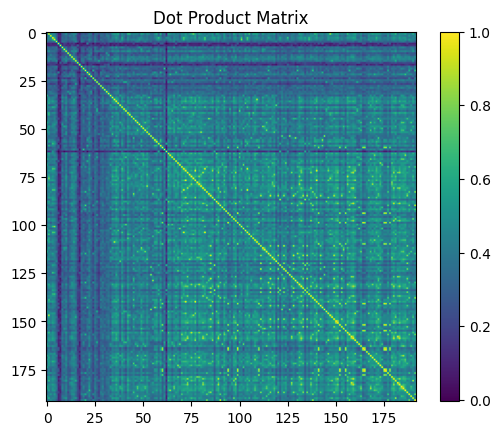

In [65]:
import matplotlib.pyplot as plt

# Plotting the dot_product_matrix
plt.imshow(dot_product_matrix, cmap='viridis')
plt.title('Dot Product Matrix')
plt.colorbar()
plt.show()



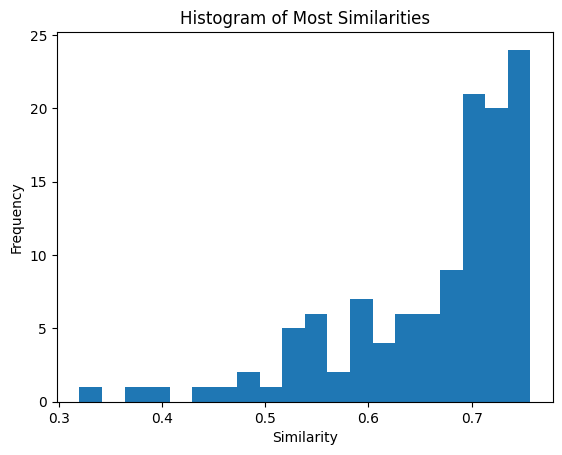

In [94]:
most_similars = (dot_product_matrix - np.eye(dot_product_matrix.shape[0])).max(axis=1)

import matplotlib.pyplot as plt

# Assuming most_similars is a numpy array
plt.hist(most_similars, bins=20)
plt.title('Histogram of Most Similarities')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()


In [103]:
len(questions_references)

97

In [115]:
sample_questions = random.sample(questions_references, 5)
sample_questions

[("What are President Biden's stated intentions regarding Social Security and Medicare, as mentioned in his State of the Union Address?",
  [('If anyone here tries to cut Social Security or Medicare or raise the retirement age, I will stop you.',
    25752,
    25853),
   ("I'll protect and strengthen Social Security and make the wealthy pay their fair share.",
    26437,
    26523)]),
 ('What outcomes have been achieved from elections regarding reproductive freedom according to President Biden?',
  [('When reproductive freedom was on the ballot, we won in 2022 and 2023.',
    6946,
    7015)]),
 ('What specific actions did President Biden mention in his address regarding the issue of student debt relief?',
  [('When I was told I couldn’t universally just change the way in which we did \n— dealt with student loans, I fixed two student loan programs that already existed to reduce the burden of student debt for nearly 4 million Americans, including nurses, firefighters and others in publ

<BarContainer object of 5 artists>

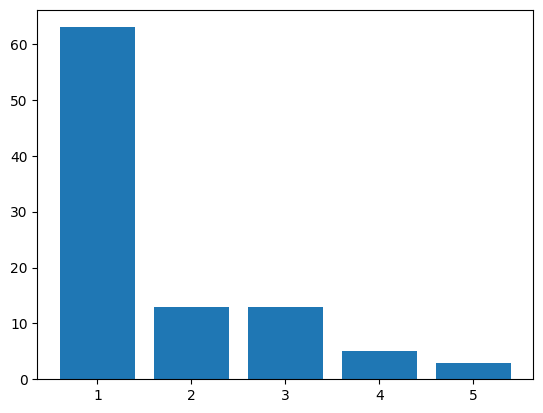

In [104]:
import matplotlib.pyplot as plt

reference_list = [len(x[1]) for x in questions_references]

counts = [reference_list.count(i) for i in range(1, 6)]
plt.bar(range(1, 6), counts)

In [118]:
tokens_per_question = []
for x in questions_references:
    token_count = 0
    for ref in x[1]:
        token_count += num_tokens_from_string(ref[0])
    tokens_per_question.append(token_count)

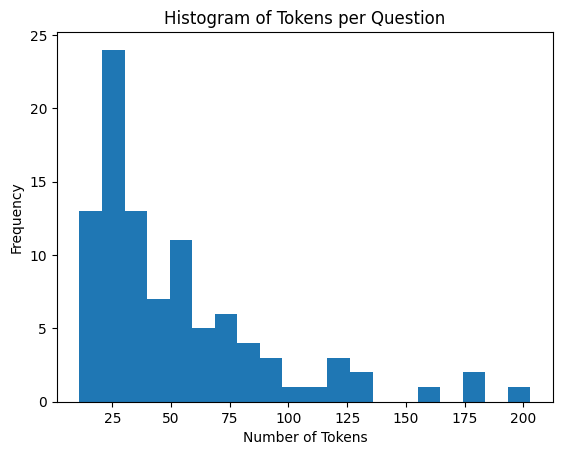

In [119]:
tokens_per_question = np.array(tokens_per_question)

plt.hist(tokens_per_question, bins=20)
plt.title('Histogram of Tokens per Question')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()


In [120]:
np.mean(tokens_per_question)

52.28865979381443